In [837]:
from qiskit import QuantumCircuit, transpile
import numpy as np
import re

In [838]:
# Target state.
Target_state = '11'

In [839]:
# matrix construction.
N = len(Target_state)
U = np.identity(2 ** N, dtype=complex)
Target_index = int(Target_state, 2)
U.itemset((Target_index, Target_index),-1)

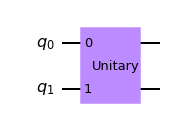

In [840]:
# Extracting the number of qubits.

qc = QuantumCircuit(N)
qc.unitary(U,[i for i in range(N)])
qc.draw('mpl')

$$
U_{3}(\theta, \phi, \lambda) = \begin{bmatrix}
\cos \frac{\theta}{2} & -e^{i \lambda} \sin \frac{\theta}{2} \\
e^{i \phi} \sin \frac{\theta}{2} & e^{i(\phi+\lambda)} \cos \frac{\theta}{2}
\end{bmatrix} 
$$

In [841]:
trans_qc = transpile(qc, basis_gates = ['cx','u3'])

## Structure of the gate_object in qiskit.
(Instruction(name='u3', num_qubits=1, num_clbits=0, params=[angle, angle, angle]), [Qubit(QuantumRegister(Total number of qubits, 'q'), Position of $U_3$)], [])


In [842]:

f = trans_qc
def List_Gates(Gate_Number):
    l = []
    Qubit = []
    Angle = []

    numeric_const_pattern = '[-+]? (?: (?: \d* \. \d+ ) | (?: \d+ \.? ) )(?: [Ee] [+-]? \d+ ) ?'
    rx = re.compile(numeric_const_pattern, re.VERBOSE)
    
    if str(trans_qc[Gate_Number][0]).split(',')[0][-3:-1] == 'u3':
        # list the three angles if the gate is u3.
        l.append(str(list(f)[Gate_Number]).split(',')[3])
        l.append(str(list(f)[Gate_Number]).split(',')[4])
        l.append(str(list(f)[Gate_Number]).split(',')[5])
        # extract the angle from the string of alphabet and digit.
        for i in l:
            if rx.findall(i) == []:
                # the angle zero is written as 0.0 .
                Angle.append(0.0)
            else:
                Angle.append(float(rx.findall(i)[0]))
        # the qubit on which u3 acts is listed.        
        Qubit.append(re.sub("\D", "", str(trans_qc[Gate_Number][1]).split(',')[2]))  
        
        # if the gate is cx then no need of angles.
    else:
        # the control and the target bit is listed.
        Control_bit = re.sub("\D", '', str(trans_qc[Gate_Number][1][0]).split(',')[2])
        Target_bit = re.sub("\D", '', str(trans_qc[Gate_Number][1][1]).split(',')[2])    
        Qubit.append([Control_bit, Target_bit])
        
    return Angle, Qubit

C_not_number = 0
U_3_number = 0
for i in range(len(f)):
    if str(trans_qc[i][0]).split(',')[0][-3:-1] == 'u3':
        print('Gate =',str(trans_qc[i][0]).split(',')[0][-3:-1],
                ' Qubit =', List_Gates(i)[1][0],', Angle =', List_Gates(i)[0])
        U_3_number = U_3_number + 1
    else:
        print('Gate =',str(trans_qc[i][0]).split(',')[0][-3:-1],
                ' Control Bit =', List_Gates(i)[1][0][0], ', Target bit =', List_Gates(i)[1][0][1])
        C_not_number = C_not_number + 1
print('Total Number of gate =', U_3_number + C_not_number,
      ', Number of U_3 =', U_3_number, ', Number of CNOT =', C_not_number)

Gate = u3  Qubit = 1 , Angle = [1.5707963267948963, -3.141592653589793, -0.7853981633974483]
Gate = cx  Control Bit = 0 , Target bit = 1
Gate = u3  Qubit = 0 , Angle = [1.1102230246251568e-16, -4.440892098500626e-16, -3.141592653589793]
Gate = u3  Qubit = 1 , Angle = [1.5707963267948966, -2.3561944901923457, 0.0]
Total Number of gate = 4 , Number of U_3 = 3 , Number of CNOT = 1


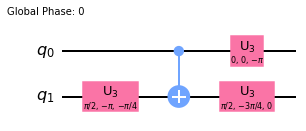

In [843]:
trans_qc.draw('mpl')